In [ ]:
from src.hpe.mp.performance import EstimationCollector

collector = EstimationCollector()
df_mp = collector.collect(name="estimations")

In [ ]:
from src.hpe.yolo.performance import EstimationCollector as YoloEstimationCollector

collector = YoloEstimationCollector()
df_yolo = collector.collect(name="estimations")

In [1]:
from src.hpe.mp.performance import read_estimations as read_mp_estimations
from src.hpe.yolo.performance import read_estimations as read_yolo_estimations

df_mp = read_mp_estimations()
df_yolo = read_yolo_estimations()

2025-10-10 09:31:08.253931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760081469.305018  990567 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760081469.647917  990567 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-10 09:31:12.311226: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


loaded labels


In [44]:
visibilities = df_mp.map(lambda x: x.predicted_landmark.visibility)

In [3]:

from src.hpe.common.typing import HpeEstimation
from pandas import Series

prediction_results = df_mp.map(HpeEstimation.prediction_result)
counts = prediction_results.apply(Series.value_counts).fillna(0)

In [12]:
from math import nan
from pandas import DataFrame
from src.common.helpers import safe_index

def _precision(totals: DataFrame, verbose: bool = False) -> float:
    if totals[""] > 0:
        return nan
    
    tp = safe_index(totals, "TP")
    fp = safe_index(totals, "FP")

    if verbose:
        print(f"TP: {tp}")
        print(f"FP: {fp}")

    if tp + fp == 0:
        return 0.0
    
    result = tp  / (tp + fp)
    if verbose:
        print(f"{tp} / ({tp} + {fp}) = {result}")

    return result

def _recall(totals: DataFrame, verbose: bool = False) -> float:
    if totals[""] > 0:
        return nan
    
    tp = safe_index(totals, "TP")
    fn = safe_index(totals, "FN")

    if verbose:
        print(f"TP: {tp}")
        print(f"FN: {fn}")

    if tp + fn == 0:
        return 0
    
    result = tp  / (tp + fn)
    if verbose:
        print(f"{tp} / ({tp} + {fn}) = {result}")
    return result

In [13]:
from typing import Dict, Tuple, List
from numpy import ndarray, array, nan, arange
from pandas import DataFrame, Series

from src.common.helpers import safe_index
from src.hpe.common.helpers import eucl_distance
from src.hpe.common.landmarks import MyLandmark, PredictedKeyPoints, YoloLabels
from src.hpe.common.typing import HpeEstimation

In [42]:
PrecisionList = List[float]
RecallList = List[float]
def calc_precision_and_recall(estimations: DataFrame) -> Tuple[DataFrame, DataFrame]:
    conf_increment = 0.01
    confidences = arange(0, 1 + conf_increment, conf_increment)
    precision_y = DataFrame()
    recall_x = DataFrame()
    
    for idx, conf in enumerate(confidences):
        
        def prediction_result(estimation: HpeEstimation) -> str:
            return estimation.prediction_result(conf)

        prediction_results = estimations.map(prediction_result)
        counts = prediction_results.apply(Series.value_counts).fillna(0)

        landmark_precisions = counts.apply(_precision, axis=0)
        landmark_precisions.at["CONFIDENCE"] = conf
        precision_y[idx] = landmark_precisions

        landmark_recalls = counts.apply(_recall, axis=0)
        landmark_recalls.at["CONFIDENCE"] = conf
        recall_x[idx] = landmark_recalls

    return precision_y, recall_x

In [43]:
pcsn, rcl = calc_precision_and_recall(df_mp)

/tmp/ipykernel_990567/2051101319.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  precision_y[idx] = landmark_precisions
/tmp/ipykernel_990567/2051101319.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  recall_x[idx] = landmark_recalls


In [41]:
pcsn.loc[MyLandmark.HEAD.name]

0     0.740741
1     0.740741
2     0.740741
3     0.740741
4     0.740741
        ...   
95    0.740741
96    0.740741
97    0.740741
98    0.740741
99    0.740741
Name: HEAD, Length: 100, dtype: float64

In [38]:
from typing import List, Tuple
from matplotlib import pyplot as plt
from pandas import DataFrame
from numpy import ones, average, nan, isnan
from numpy.ma import masked_array

In [54]:
def plot_precision_recall_curve(precision_y: DataFrame, recall_x: DataFrame,
        tight: bool = True):
    
    for landmark in MyLandmark:
        plt.plot(recall_x.loc[landmark.name][1:-1], precision_y.loc[landmark.name][1:-1])
        
    plt.title("Precision Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    #plt.legend([landmark.name for landmark in MyLandmark])

    if not tight:
        plt.xlim(0, 1)
        plt.ylim(0, 1)

In [56]:
def plot_precision_and_recall(precision_y: DataFrame, recall_x: DataFrame,
        tight: bool = True):
    
    plt.figure()
    plt.subplot(121)
    for landmark in MyLandmark:
        plt.plot(precision_y.loc[landmark.name], precision_y.loc["CONFIDENCE"])
        
    plt.title("Precision")
    plt.xlabel("Confidence")
    plt.ylabel("Precision")
    #plt.legend([landmark.name for landmark in MyLandmark])

    plt.subplot(122)
    for landmark in MyLandmark:
        plt.plot(recall_x.loc[landmark.name], recall_x.loc["CONFIDENCE"])
        
    plt.title("Recall")
    plt.xlabel("Confidence")
    plt.ylabel("Recall")
    
    if not tight:
        plt.xlim(0, 1)
        plt.ylim(0, 1)

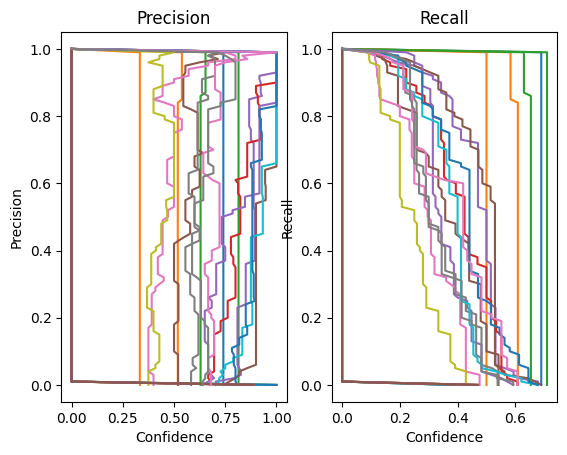

In [57]:
plot_precision_and_recall(pcsn, rcl)

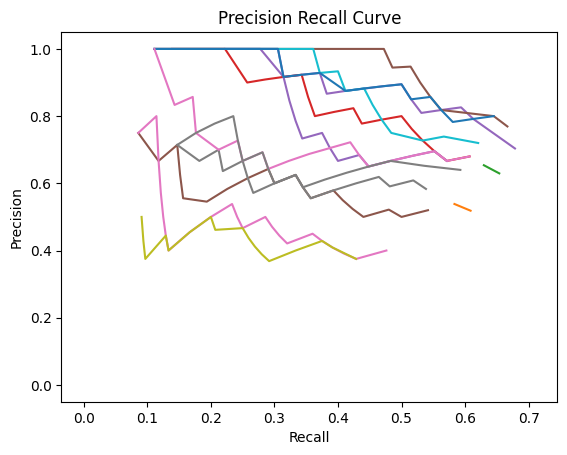

In [55]:
plot_precision_recall_curve(pcsn, rcl)

In [ ]:

def calc_average_precision(precision_list: PrecisionList, recall_list: RecallList,
        verbose: bool = False):
    average_precision = 0
    previous_recall = 0

    for precision, recall in zip(precision_list, recall_list):
        average_precision = average_precision + abs(recall - previous_recall) * precision
        previous_recall = recall
    
    if verbose: print(f"Average precision is: {average_precision}")

    return average_precision

def calc_average_precisions(precision_list: DataFrame, recall_list: DataFrame,
        verbose: bool = False) -> List[float]:
    average_precisions = []
    
    for landmark in MyLandmark:
        ap = calc_average_precision(precision_list.loc[landmark.name], recall_list.loc[landmark.name], verbose)
        average_precisions = [*average_precisions, ap]

    return average_precisions

def calc_mean_average_precision(precision_list: DataFrame, recall_list: DataFrame,
        verbose: bool = False) -> float:
    aps = calc_average_precisions(precision_list, recall_list, verbose)
    return average(aps)

In [60]:
aps = calc_average_precisions(pcsn, rcl)
map = calc_mean_average_precision(pcsn, rcl)

In [ ]:
from src.hpe.common.typing import HpeEstimation

df_mp_true = df_mp.map(lambda x: x.true_landmark)

In [ ]:
fp_pred = df_mp.iloc[9]['HEAD']
fp_pred.prediction_result(verbose=True)

In [ ]:
fp_pred = df_yolo.iloc[9]['HEAD']
fp_pred.prediction_result(verbose=True)

In [ ]:
from src.hpe.common.metrics import calc_precision_and_recall

prec, rec = calc_precision_and_recall(df_mp)

In [ ]:
from src.hpe.common.plot import plot_precision_recall_curve
plot_precision_recall_curve(prec, rec)

In [ ]:
from src.hpe.yolo.performance import read_distances as read_yolo_distances
from src.hpe.mp.performance import read_distances as read_mp_distances
from src.hpe.common.plot import plot_distances_boxplot

mp_dist = read_mp_distances(dataset_name="distances")
mp_bgr_dist = read_mp_distances(dataset_name="distances_bgr")

yolo_dist = read_yolo_distances(dataset_name="distances")
yolo_bgr_dist = read_yolo_distances(dataset_name="distances_bgr")

In [ ]:
plot_distances_boxplot(
    None,
    ("MediaPipe", mp_dist),
    ("MediaPipe on bgr", mp_bgr_dist),
    ("Yolov11", yolo_dist),
    ("Yolov11 on bgr", yolo_bgr_dist))

In [ ]:
plot_distances_boxplot(
    (0, 10),
    ("MediaPipe", mp_dist),
    ("MediaPipe on bgr", mp_bgr_dist),
    ("Yolov11", yolo_dist),
    ("Yolov11 on bgr", yolo_bgr_dist))

In [ ]:
from src.hpe_dnn.kfold import HpeDnnFoldCrossValidation
from src.sota.kfold import SOTAFoldCrossValidation
from src.common.plot import box_plot_accuracies

box_plot_accuracies(
    HpeDnnFoldCrossValidation.evaluation_instance("arch1-mp-kf"),
    HpeDnnFoldCrossValidation.evaluation_instance("arch1-mp-unbalanced-kf"),
    HpeDnnFoldCrossValidation.evaluation_instance("arch1-mp-dr0.3-kf"),
    HpeDnnFoldCrossValidation.evaluation_instance("arch1-yolo-kf"),
    # HpeDnnFoldCrossValidation.evaluation_instance("arch2-kf"), 
    # HpeDnnFoldCrossValidation.evaluation_instance("arch3-kf"), 
    # HpeDnnFoldCrossValidation.evaluation_instance("arch4-kf"), 
    # HpeDnnFoldCrossValidation.evaluation_instance("arch5-kf"),
    SOTAFoldCrossValidation.evaluation_instance("yolo11n-kf", "yolov11n-cls"))